In [2]:
import scvelo as scv
import scanpy as sc, numpy as np, pandas as  pd, anndata as ad

In [3]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=150, frameon=False)

# Step 1: Load Data

In [4]:
adata = sc.read_h5ad('../data/processed/cells_postprocessed.h5ad')

In [5]:
# load loom files for spliced/unspliced matrices
ldata = scv.read('../data/processed/Pituitary_velocyto_all.loom', cache=True)
ldata.var_names_make_unique()

In [6]:
# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata)

In [7]:
# subsetting anndata object
hdata = adata[adata.obs.cell_type_brief.isin(['Som','Lac','Cort','Mel','Gonad','Thyro'])]

In [8]:
hdata = hdata[hdata.obs.treat.isin(['Saline','LPS','Poly(i:c)'])]

# Step 2-1: Pou1f1-dependent lineage
## Step 2-1-1: Recompute UMAP embedding

In [9]:
pou1f1_dep = hdata[hdata.obs.cell_type_brief.isin(['Som','Lac','Thyro'])]

In [10]:
sc.pp.normalize_total(pou1f1_dep, target_sum=1e4)
sc.pp.log1p(pou1f1_dep)
sc.pp.highly_variable_genes(pou1f1_dep, min_mean=0.0125, max_mean=3, min_disp=0.5)
pou1f1_dep.raw = pou1f1_dep
pou1f1_dep = pou1f1_dep[:, pou1f1_dep.var.highly_variable]
sc.pp.regress_out(pou1f1_dep, ['nCount_RNA'])
sc.pp.scale(pou1f1_dep, max_value=10)

In [11]:
sc.tl.pca(pou1f1_dep, svd_solver='arpack')
sc.pp.neighbors(pou1f1_dep, n_neighbors=15, n_pcs=50)
sc.tl.umap(pou1f1_dep)

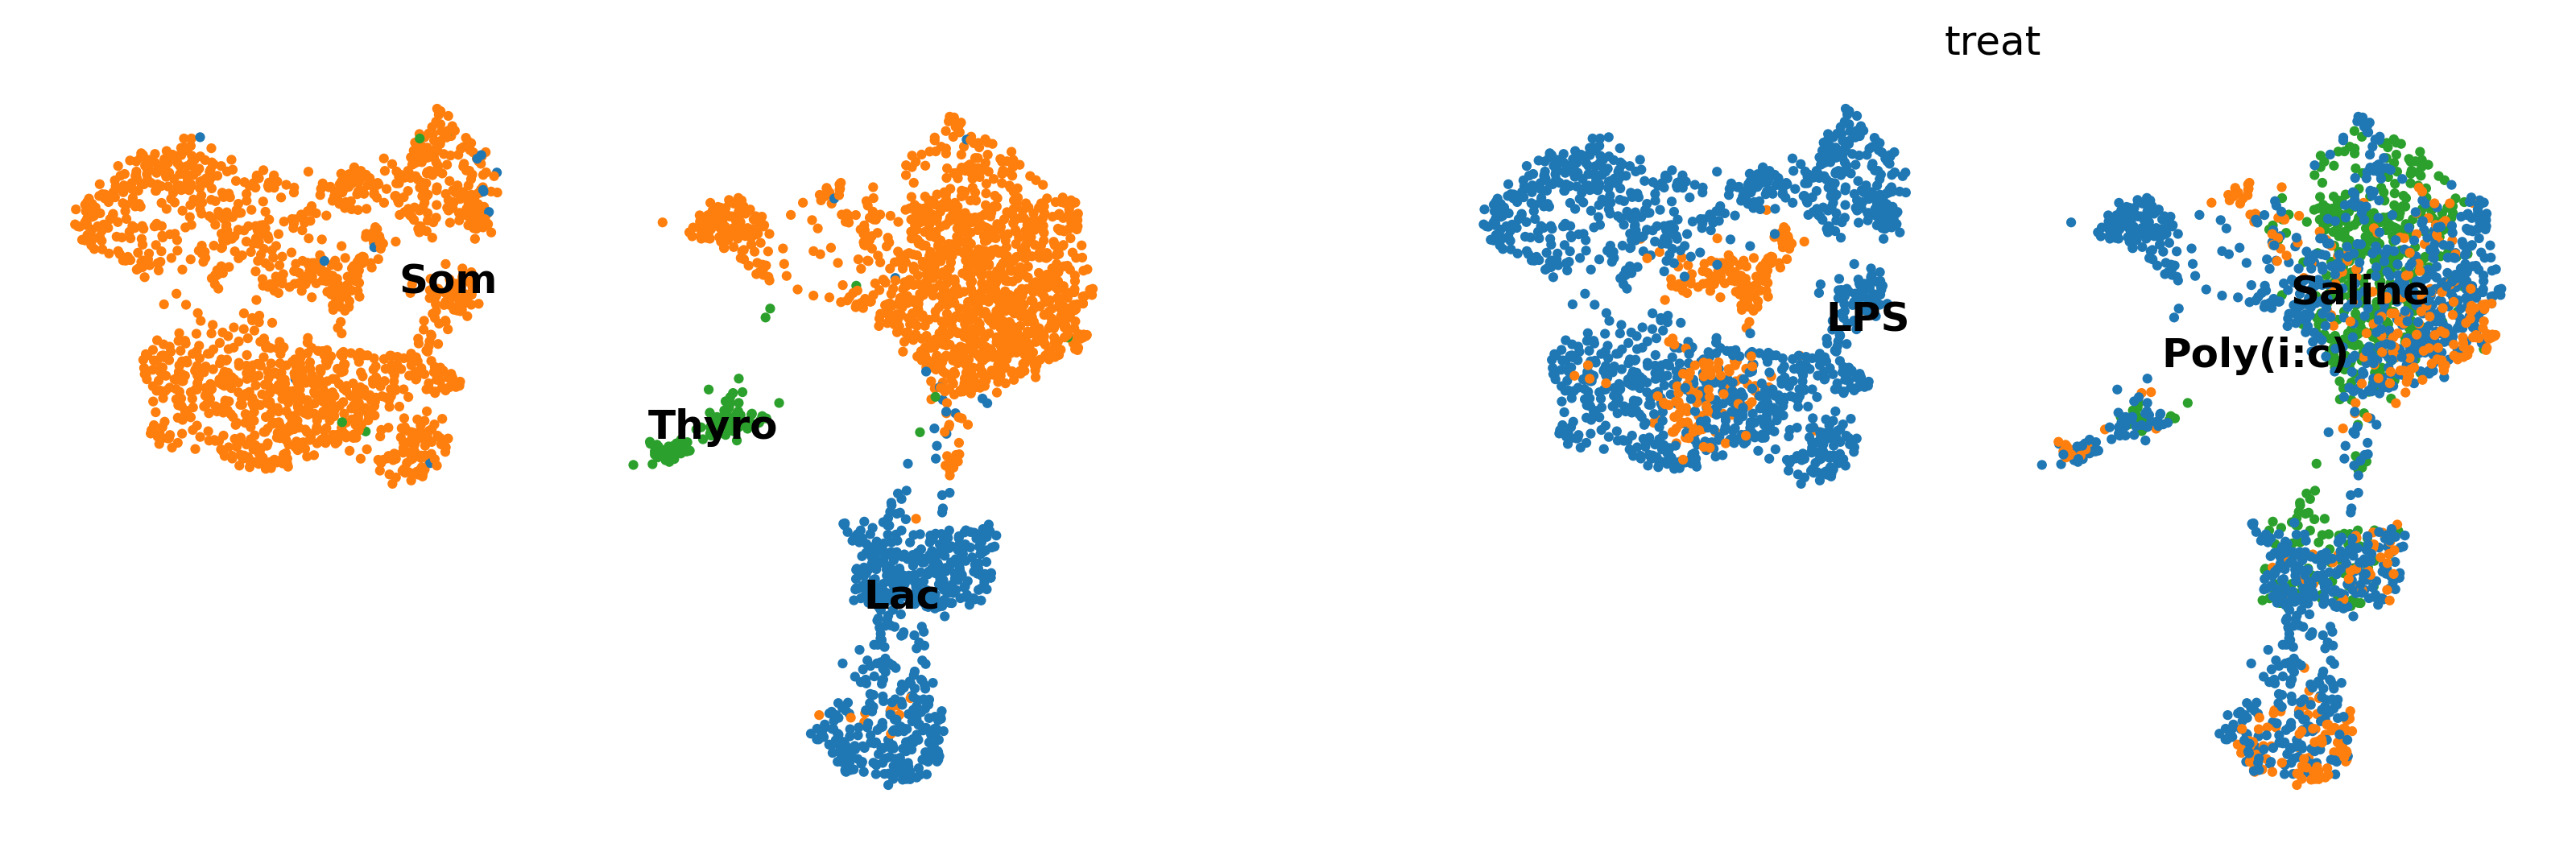

In [12]:
# plot umap to check
sc.pl.umap(pou1f1_dep, color=['cell_type_brief','treat'], frameon=False, legend_loc='on data', title='')

## Step 2-1-2: Computing RNA velocity using scvelo dymanic model

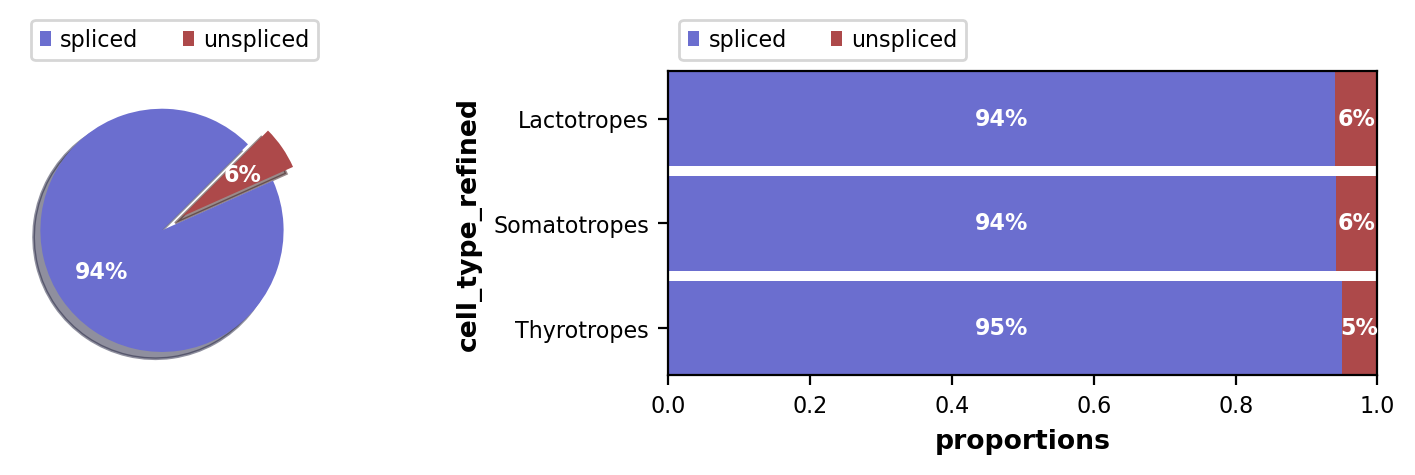

In [13]:
scv.pl.proportions(pou1f1_dep, groupby='cell_type_refined')

In [14]:
# pre-process
scv.pp.filter_and_normalize(pou1f1_dep)
scv.pp.moments(pou1f1_dep)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [15]:
sc.tl.leiden(pou1f1_dep)

In [16]:
scv.tl.recover_dynamics(pou1f1_dep, n_jobs=16)

recovering dynamics (using 16/48 cores)


  0%|          | 0/278 [00:00<?, ?gene/s]

    finished (0:00:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [17]:
# compute velocity using the dynamical model (Bergen., 2020), i.e. mode='dynamical'
scv.tl.velocity(pou1f1_dep, mode='dynamical')
scv.tl.velocity_graph(pou1f1_dep)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/3472 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


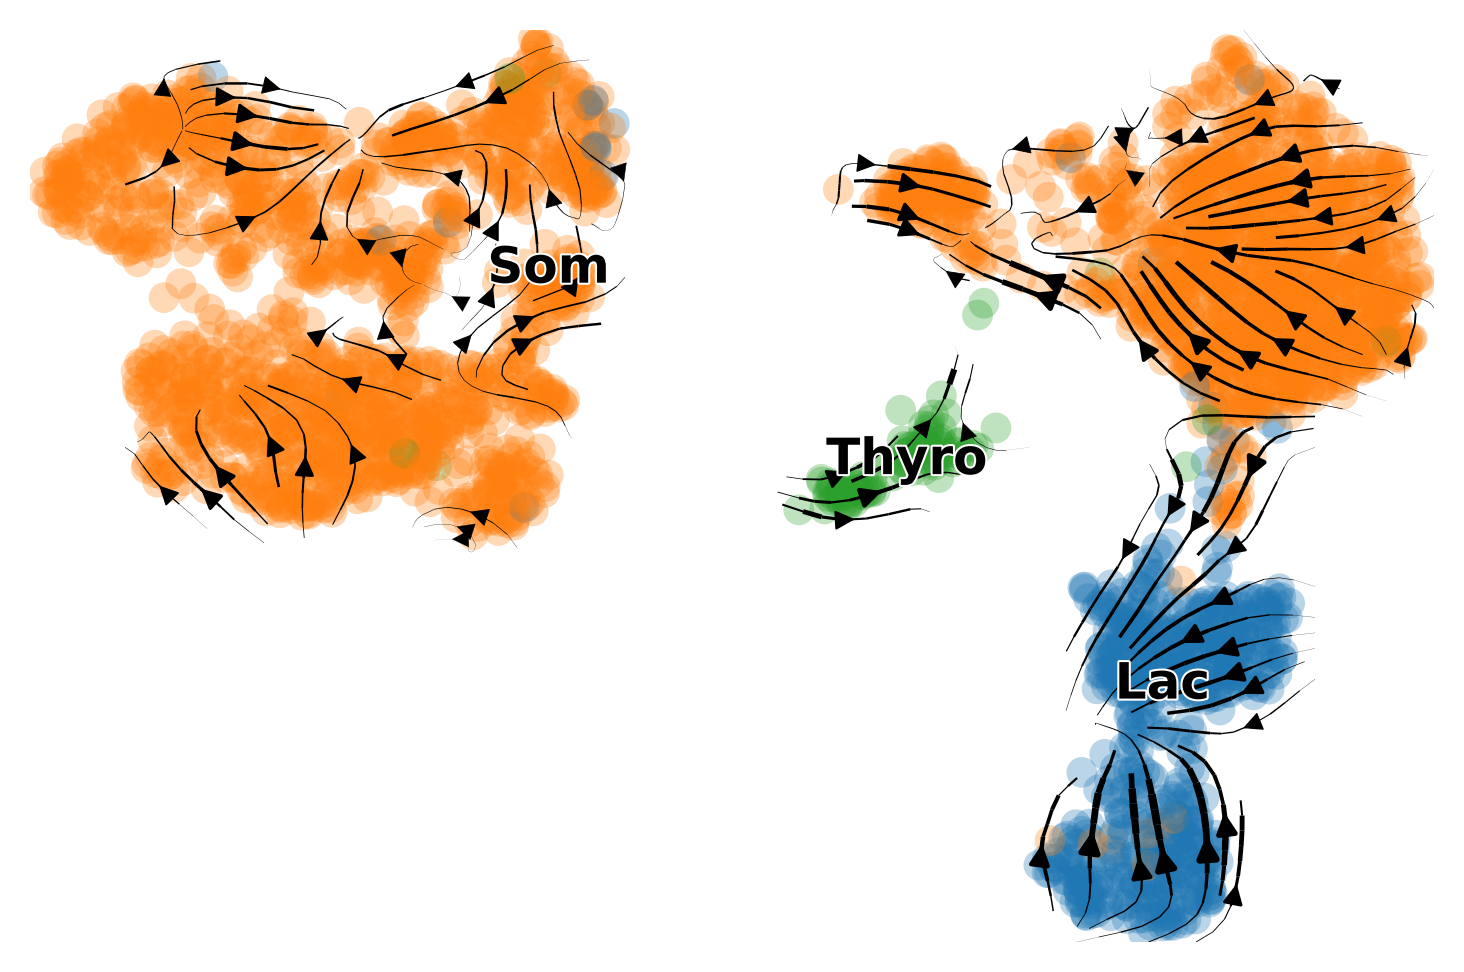

In [18]:
scv.pl.velocity_embedding_stream(pou1f1_dep, basis='umap', color='cell_type_brief', title='')

## Step 2-1-3: Downstream analysis

### Speed and coherence
* Speed: length of the velocity vector
* Coherence: how well a velocity vector correlates to its neighbors

These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


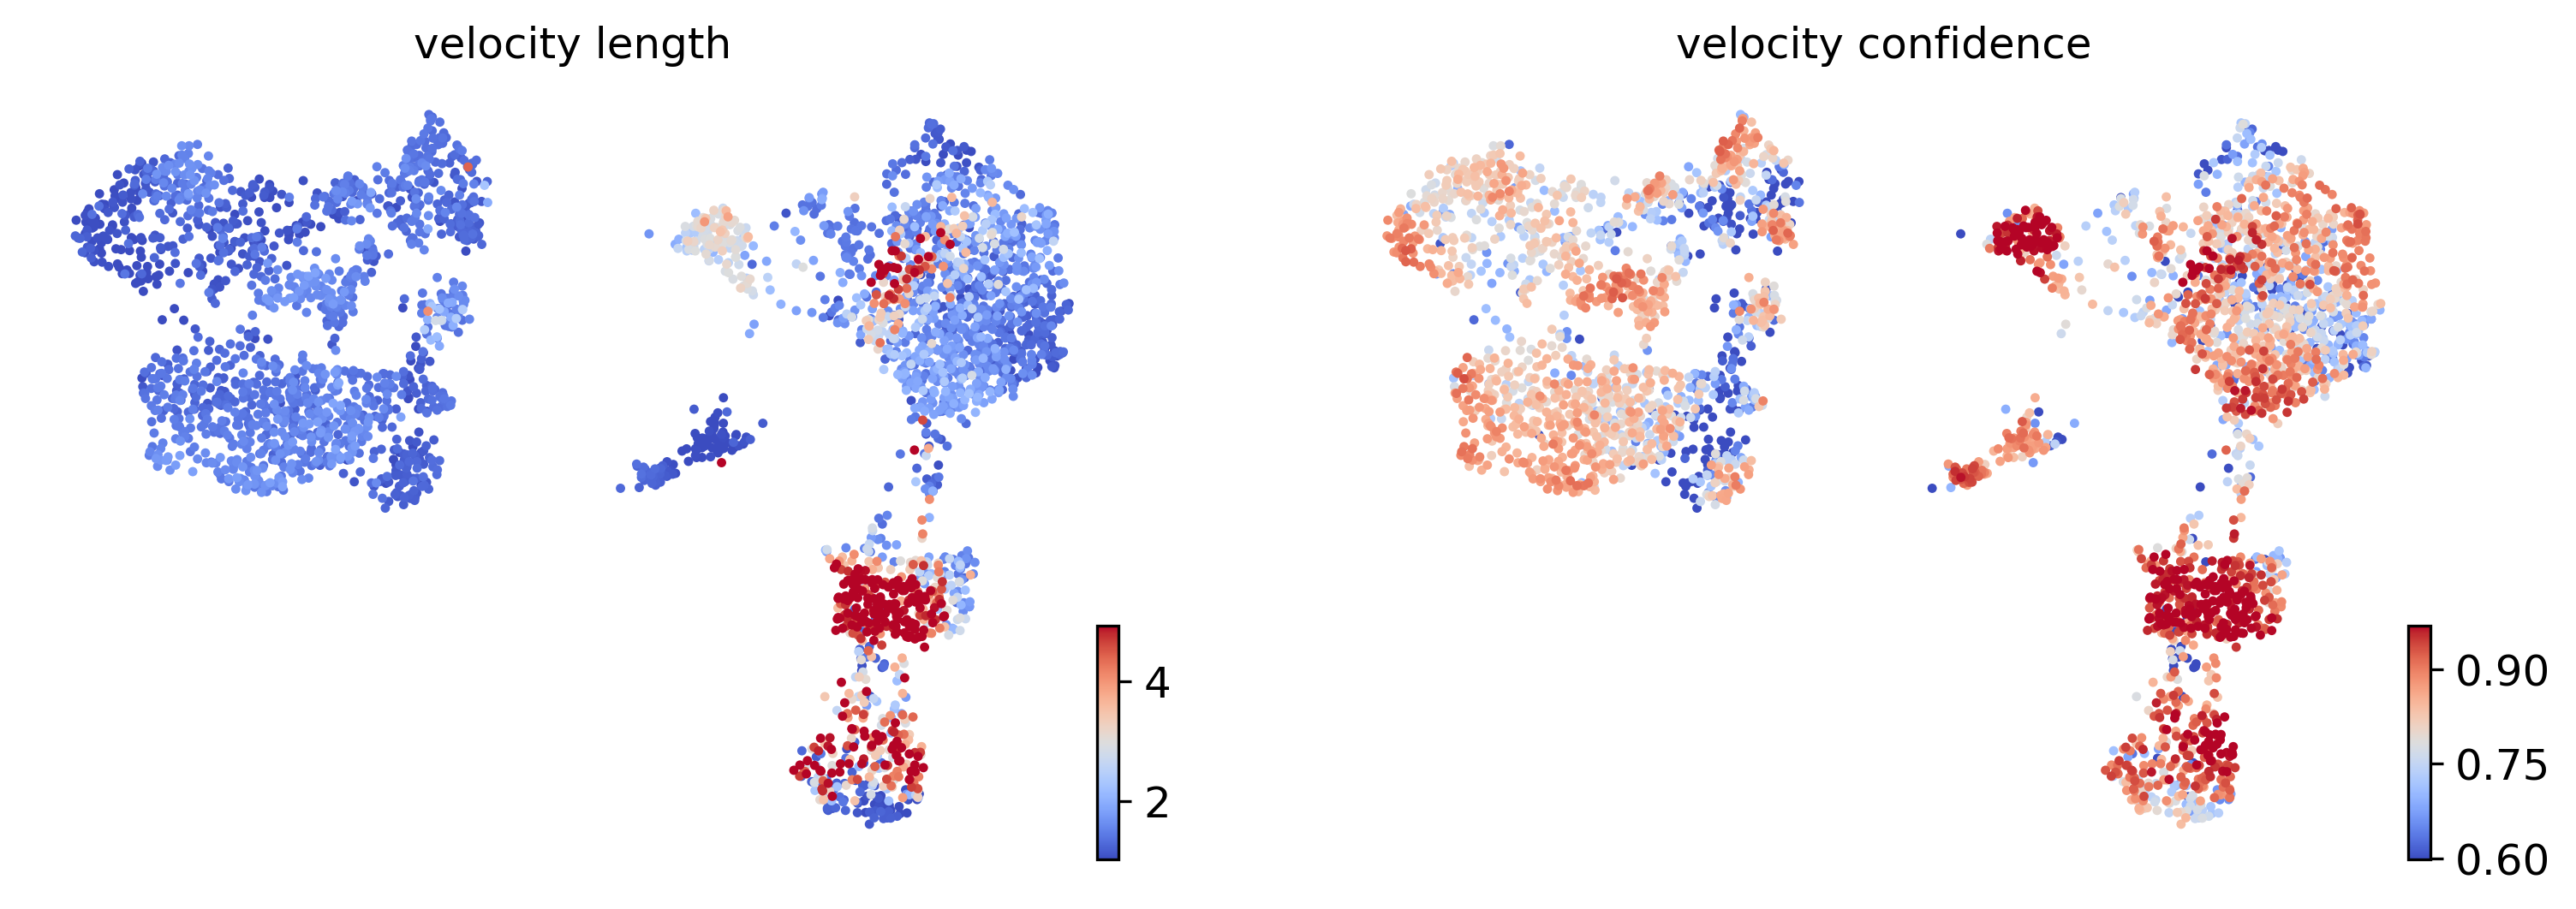

In [19]:
scv.tl.velocity_confidence(pou1f1_dep)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(pou1f1_dep, c=keys, cmap='coolwarm', perc=[5,95])

### Differential kinetic test

Not very informative in our case.  
It appears that the population size across different cell types strongly biased the results.  
Ideally, this should be done on a master object containing all HPCs.

In [27]:
var_names = ['Pcsk2']
scv.tl.differential_kinetic_test(pou1f1_dep, var_names=var_names, groupby='cell_type_brief')

testing for differential kinetics
    finished (0:00:00) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)

outputs model fit of gene: Pcsk2


In [28]:
scv.get_df(pou1f1_dep[:, var_names], ['fit_diff_kinetics', 'fit_pval_kinetics'])

fit_diff_kinetics  fit_pval_kinetics
Pcsk2               Som       7.012412e-08

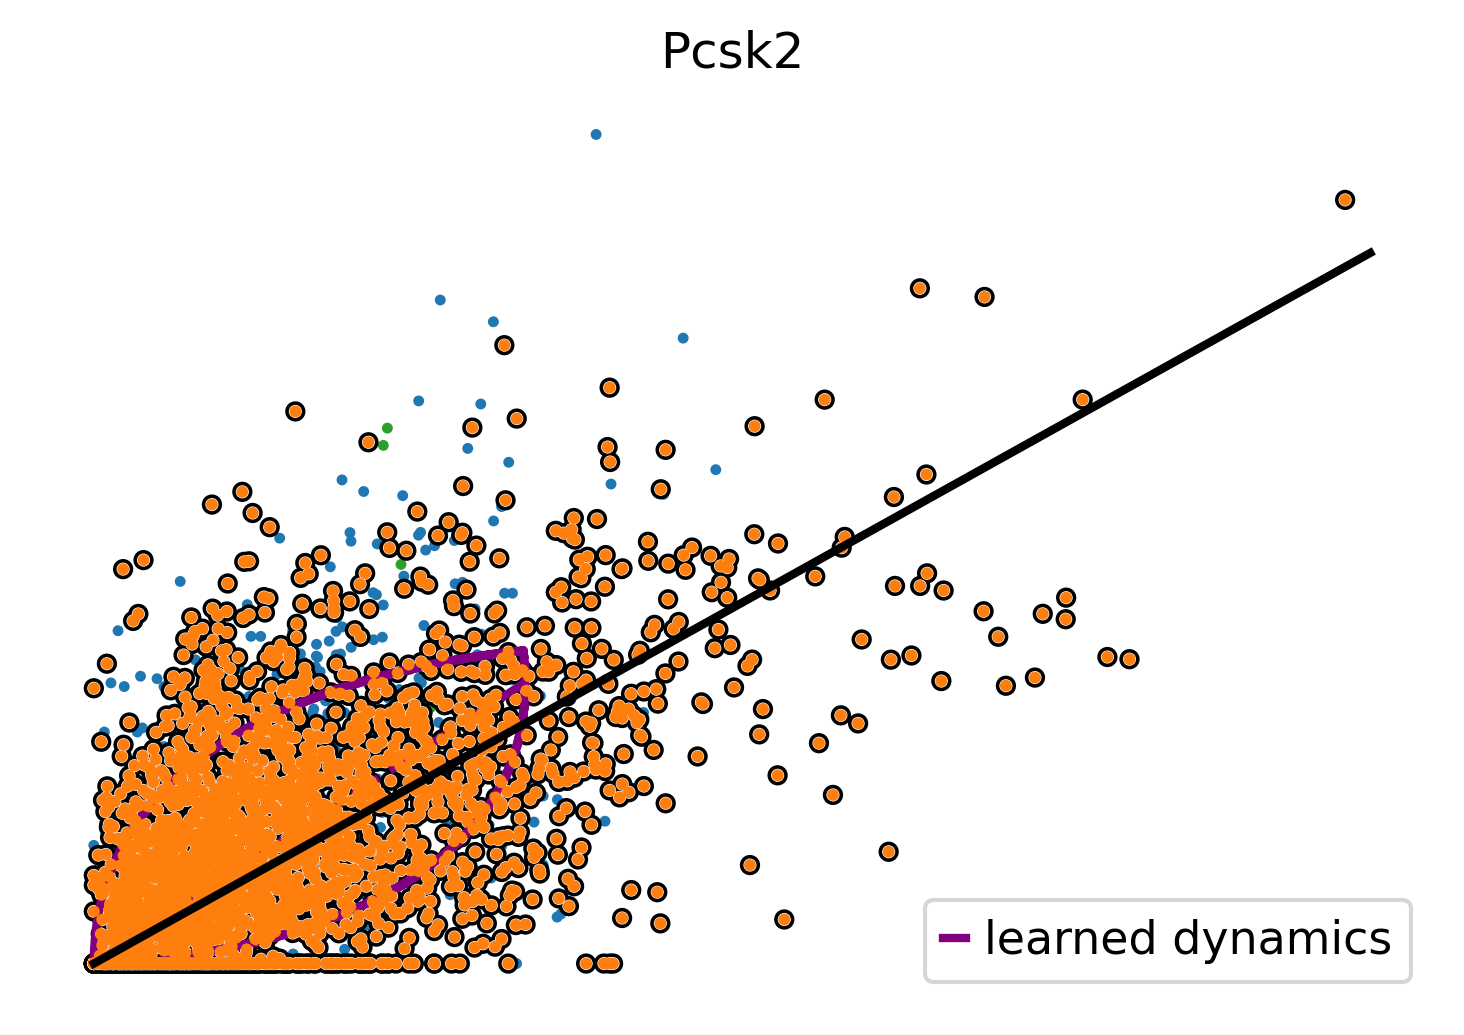

In [29]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(pou1f1_dep, basis=var_names, add_outline='fit_diff_kinetics', **kwargs)

### Kinetic rate parameters

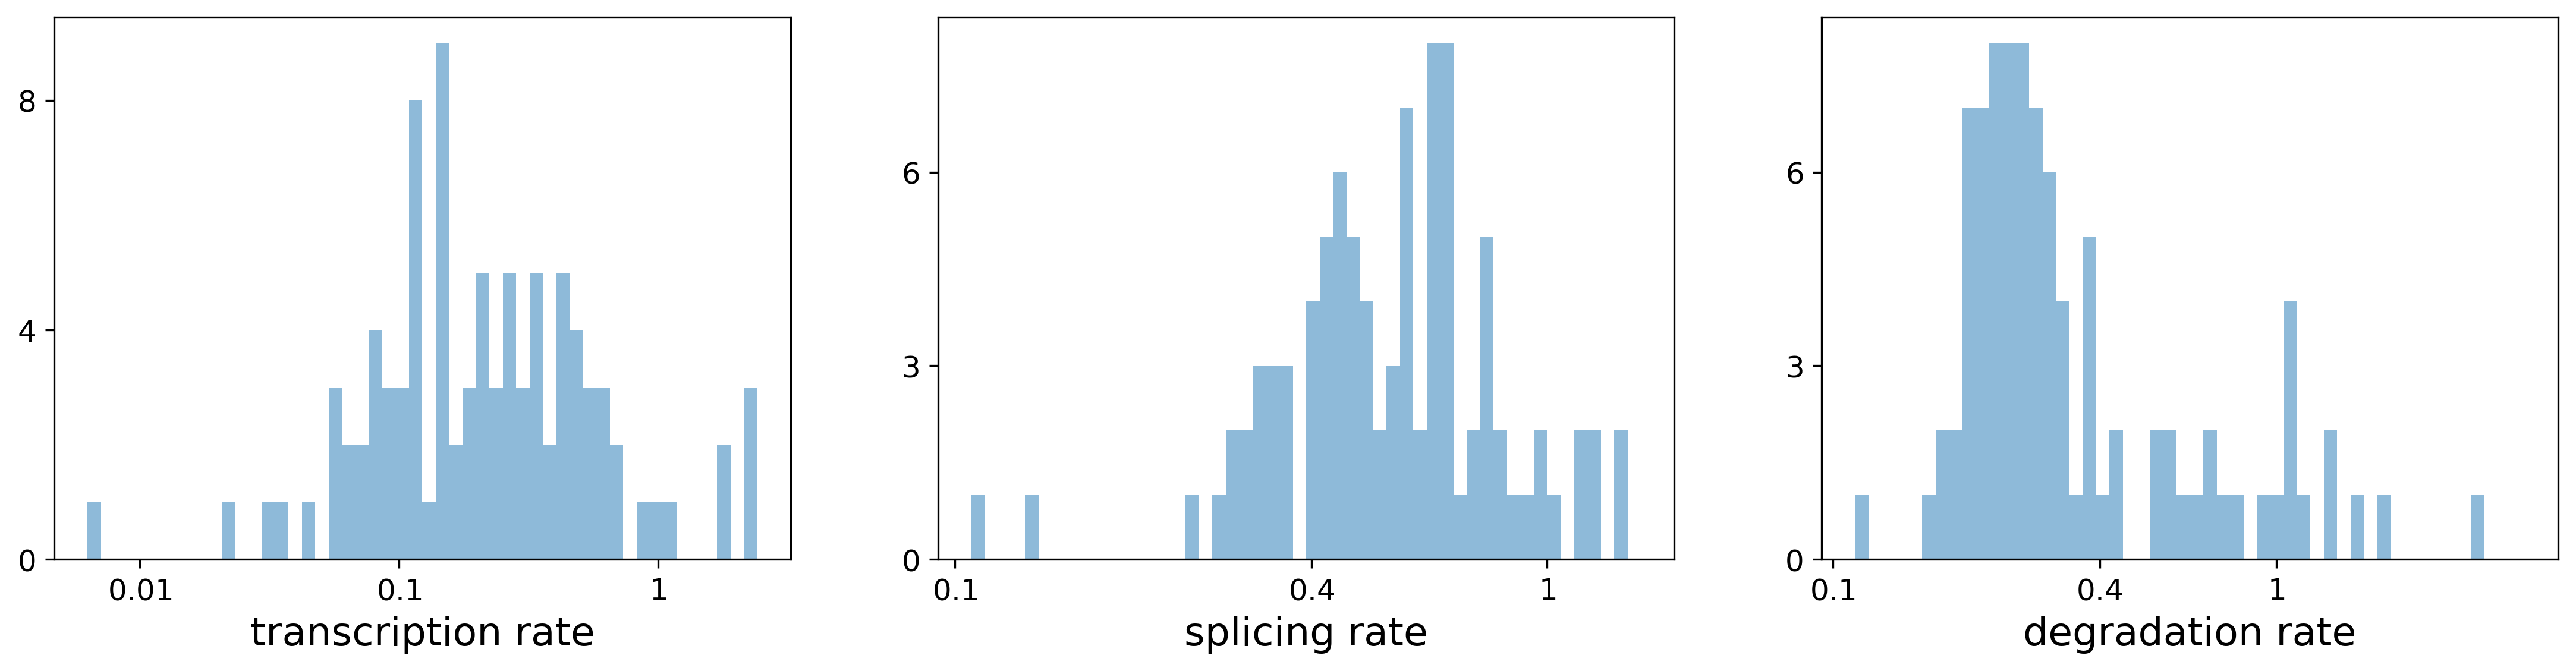

fit_r2  fit_alpha  fit_beta  fit_gamma     fit_t_  \
1110017D15Rik  0.101401   0.123282  2.725680   0.871494   6.037886   
1700125H03Rik  0.060628   0.008560  0.265430   0.207769  66.494678   
2900041M22Rik  0.037134   0.057805  6.571941   1.029823  16.278359   
2900052L18Rik  0.040656   0.092093  1.716528   0.247640   5.570669   
A2m            0.183434   0.176890  2.185837   0.246180   3.620052   

               fit_scaling  fit_std_u  fit_std_s  fit_likelihood  fit_u0  \
1110017D15Rik     0.143623   0.011564   0.040257        0.069762     0.0   
1700125H03Rik     0.419048   0.007647   0.008212        0.000010     0.0   
2900041M22Rik     0.197300   0.002388   0.013131        0.000233     0.0   
2900052L18Rik     0.488052   0.019239   0.059131        0.160279     0.0   
A2m               0.441195   0.031054   0.073905        0.000001     0.0   

               fit_s0  fit_pval_steady  fit_steady_u  fit_steady_s  \
1110017D15Rik     0.0     1.172231e-01      0.026828      0.092319   
1700125H03Rik     0.0     1.710361e-13      0.022940      0.024070   
2900041M22Rik     0.0     5.490347e-07      0.008964      0.056180   
2900052L18Rik     0.0     1.866218e-01      0.053592      0.167580   
A2m               0.0     4.719258e-01      0.123932      0.267524   

               fit_variance  fit_alignment_scaling  
1110017D15Rik      0.219051               1.277232  
1700125H03Rik      0.328772               4.925838  
2900041M22Rik      1.145883               0.651455  
2900052L18Rik      1.340117               1.790501  
A2m                1.910133               1.088781

In [20]:
df = pou1f1_dep.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(pou1f1_dep, 'fit*', dropna=True).head()

In [21]:
scv.get_df(pou1f1_dep, 'fit*', dropna=True).to_csv("../outs/scvelo/pou1f1_dep_kinetic_params.csv")

### Latent time
Omitted since it's not relevant.

### Velocity graph
We can visualize the velocity graph to potray all velocity-inferred cell-to-cell connections/transitions. It can be confined to high-probability transitions by setting a `threshold`.

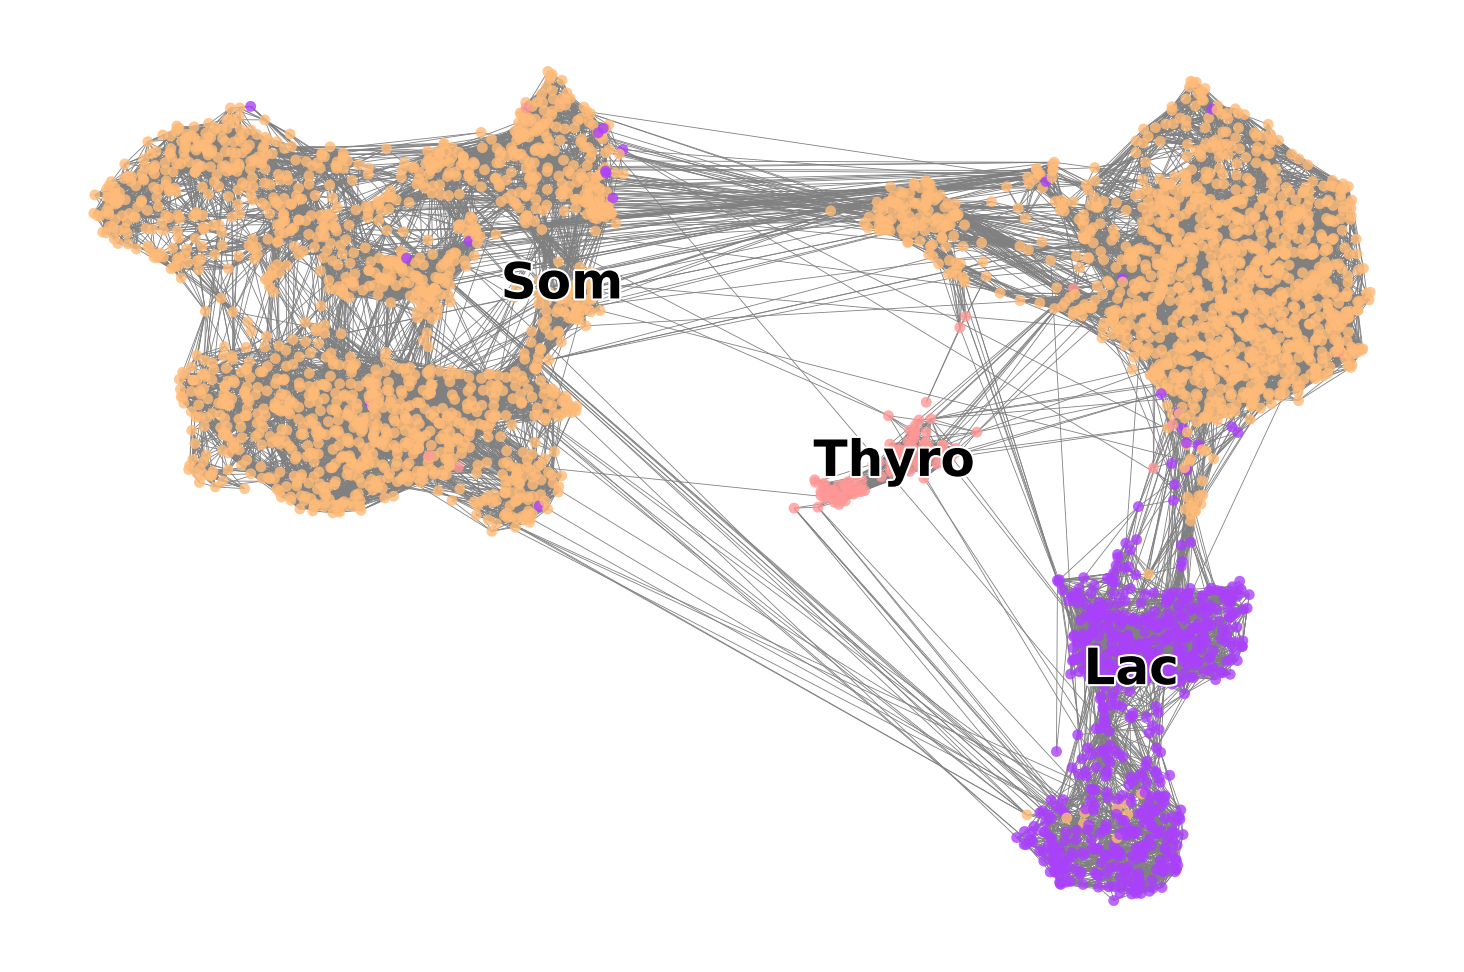

In [22]:
scv.pl.velocity_graph(pou1f1_dep, threshold=.1, color='cell_type_brief', legend_loc='on data', title='')

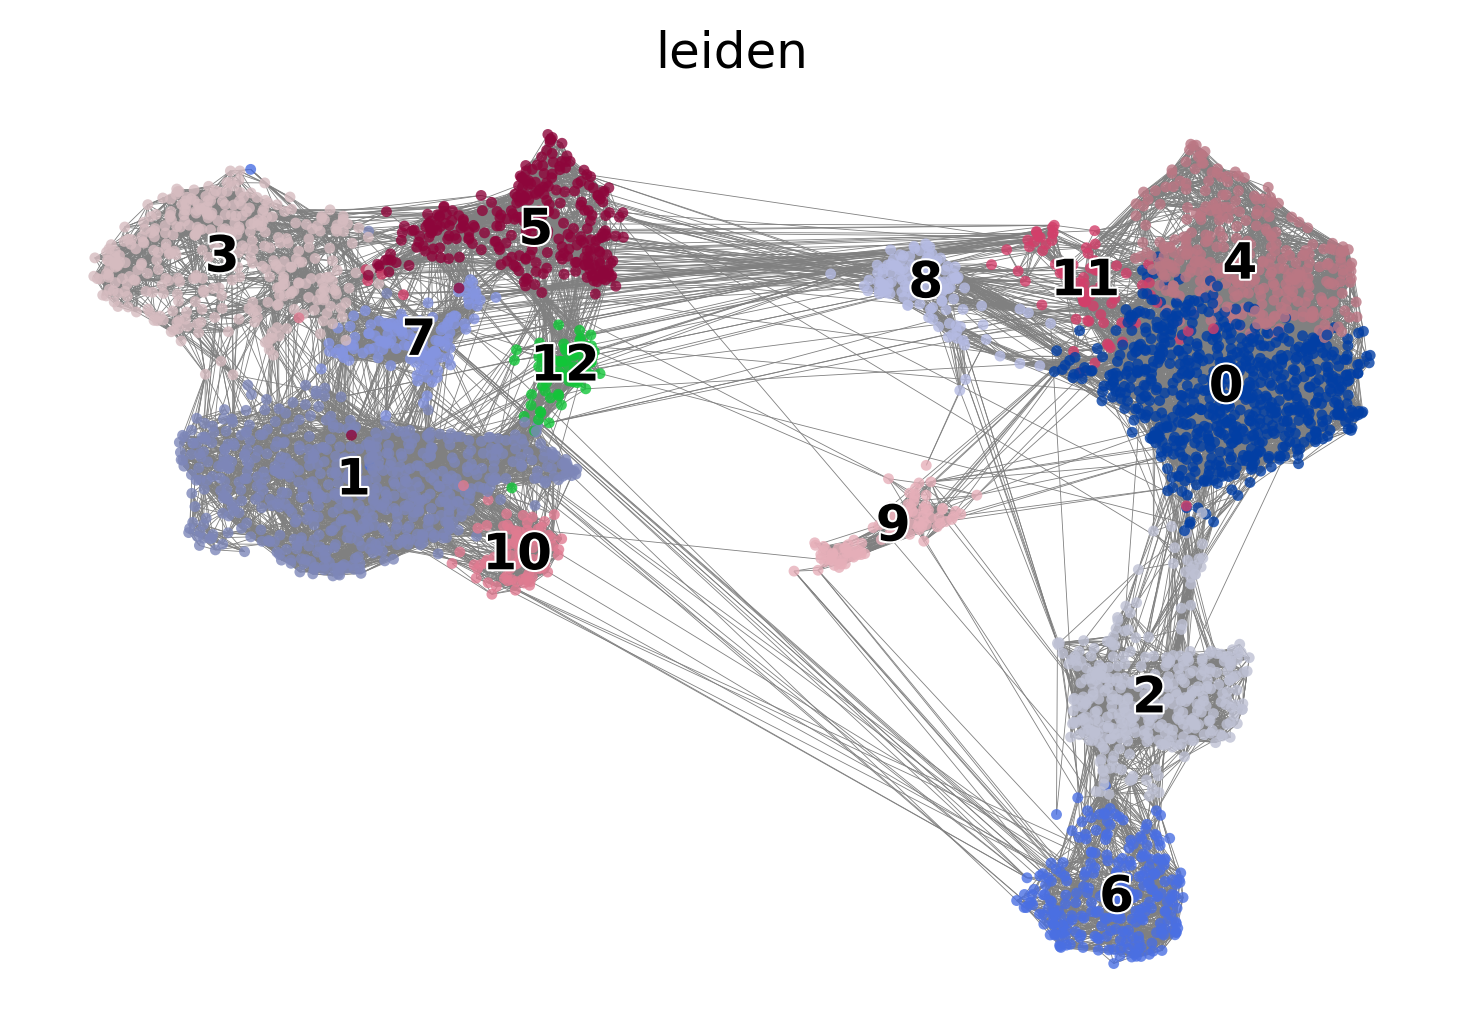

In [23]:
scv.pl.velocity_graph(pou1f1_dep, threshold=.1, color='leiden', legend_loc='on data')

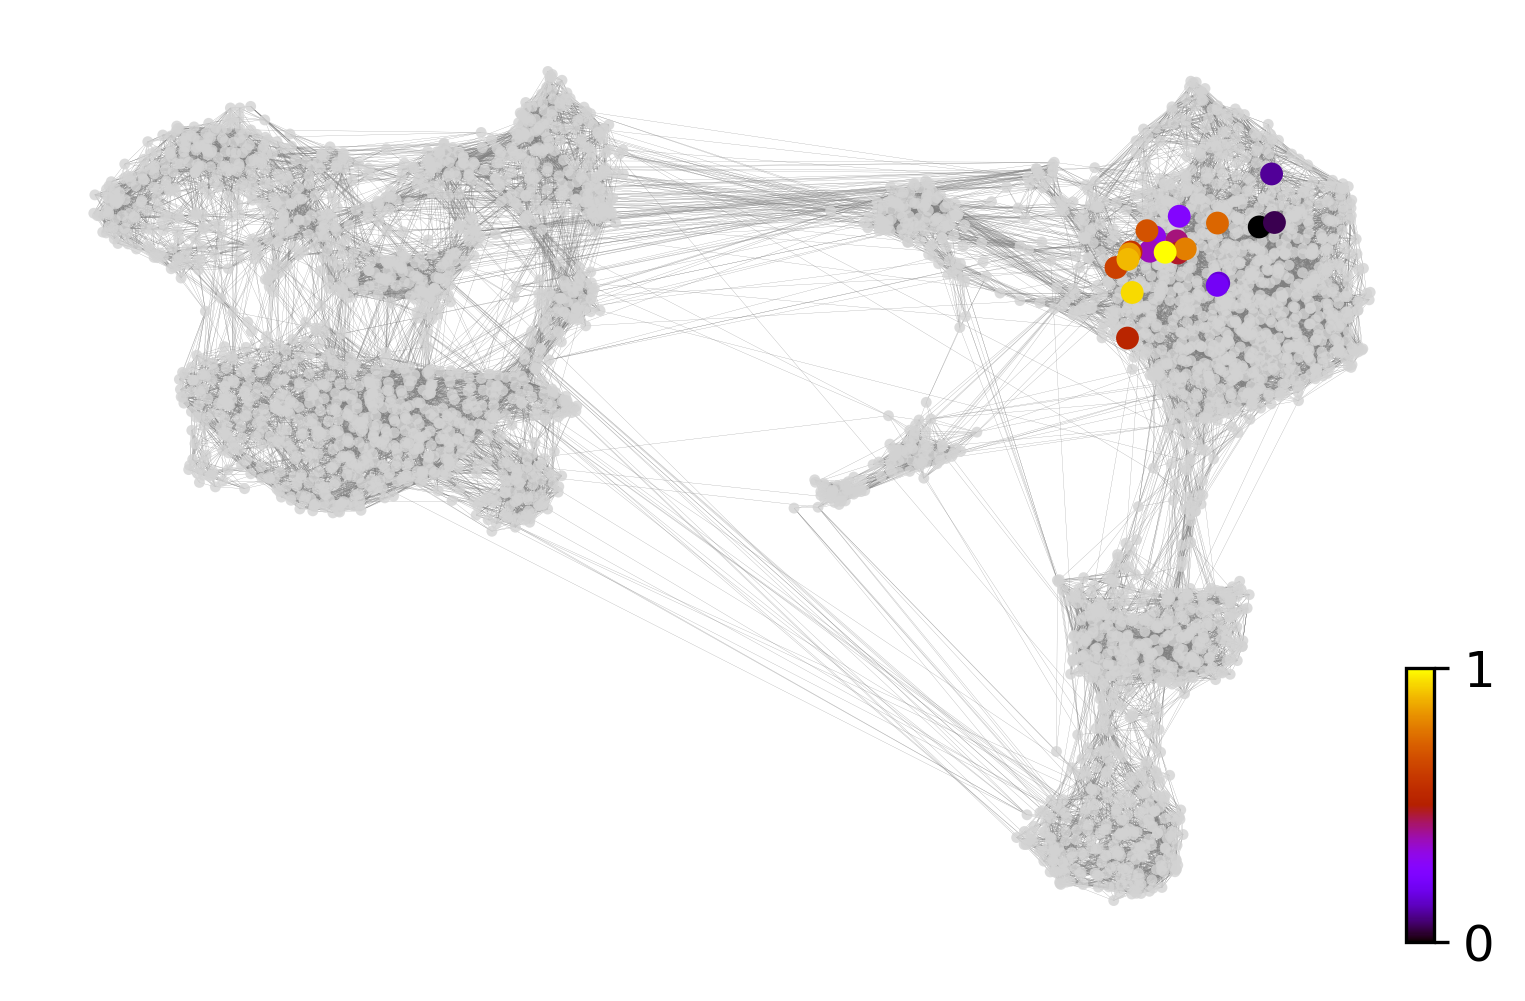

In [24]:
x, y = scv.utils.get_cell_transitions(pou1f1_dep, basis='umap', starting_cell=5)
ax = scv.pl.velocity_graph(pou1f1_dep, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(pou1f1_dep, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


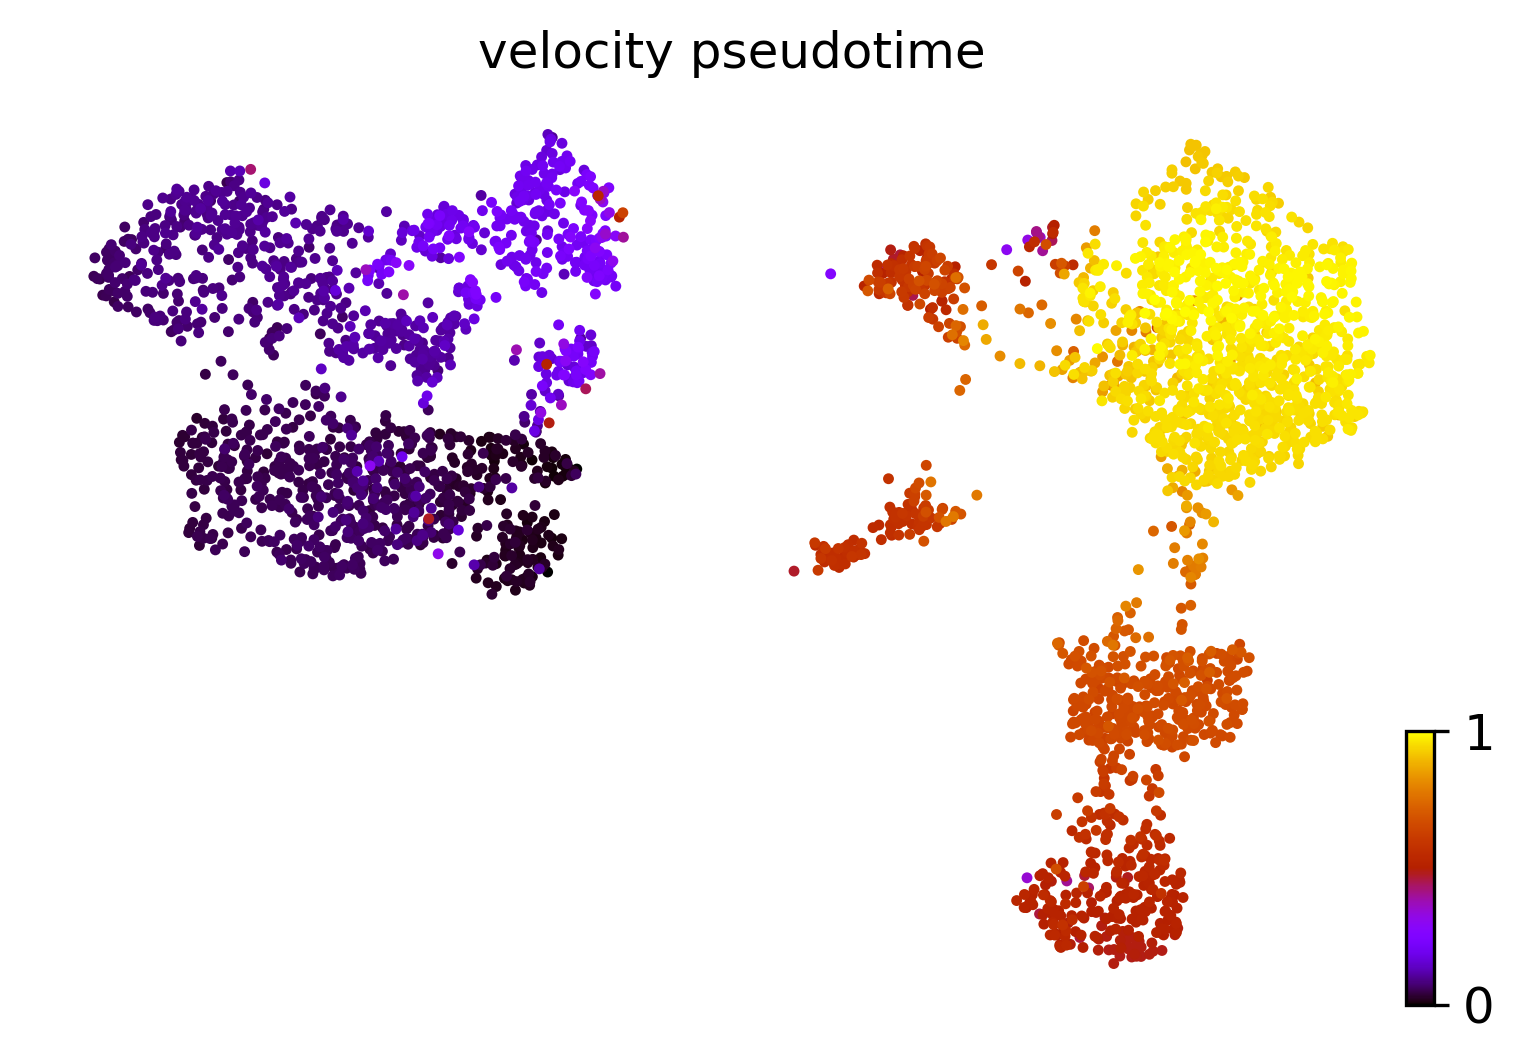

In [25]:
scv.tl.velocity_pseudotime(pou1f1_dep)
scv.pl.scatter(pou1f1_dep, color='velocity_pseudotime', cmap='gnuplot')

In [26]:
pou1f1_dep.uns['neighbors']['distances'] = pou1f1_dep.obsp['distances']
pou1f1_dep.uns['neighbors']['connectivities'] = pou1f1_dep.obsp['connectivities']

In [27]:
scv.tl.paga(pou1f1_dep, groups='leiden')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


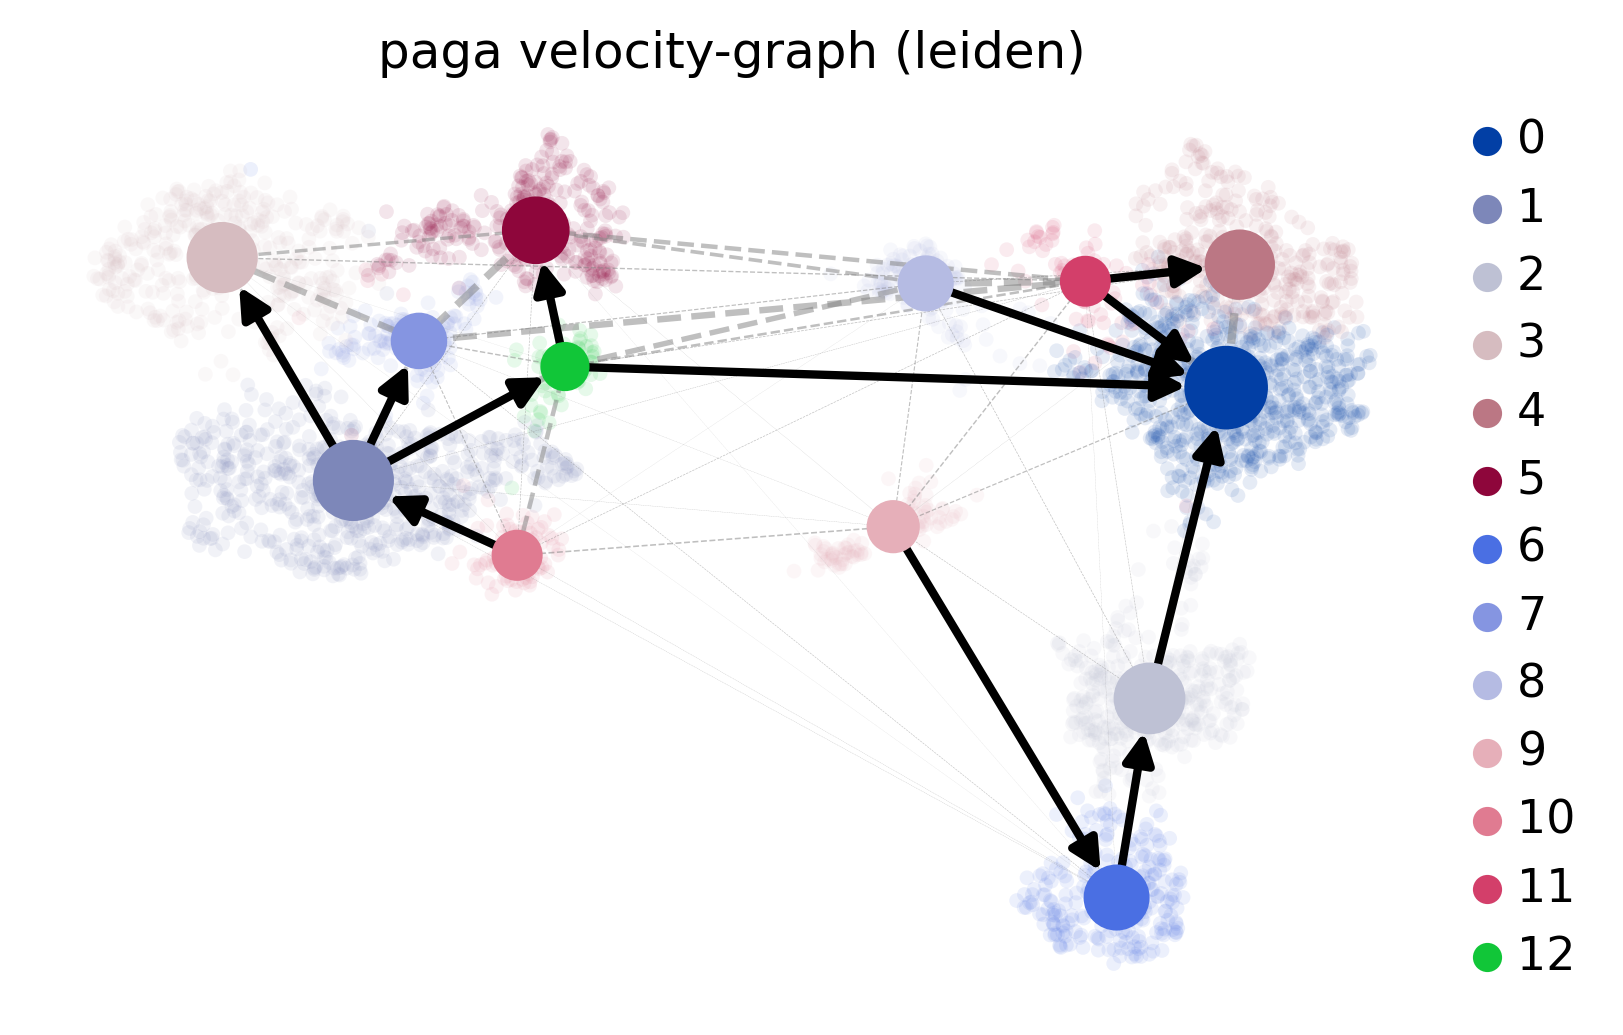

In [28]:
scv.pl.paga(pou1f1_dep, basis='umap', size=50, alpha=.1,
           min_edge_width=2, node_size_scale=1.5)

### Top-likelihood genes
Driver genes display pronounced dynamic behavior and are systematically detected via their characterization by high likelihoods in the dynamic model.

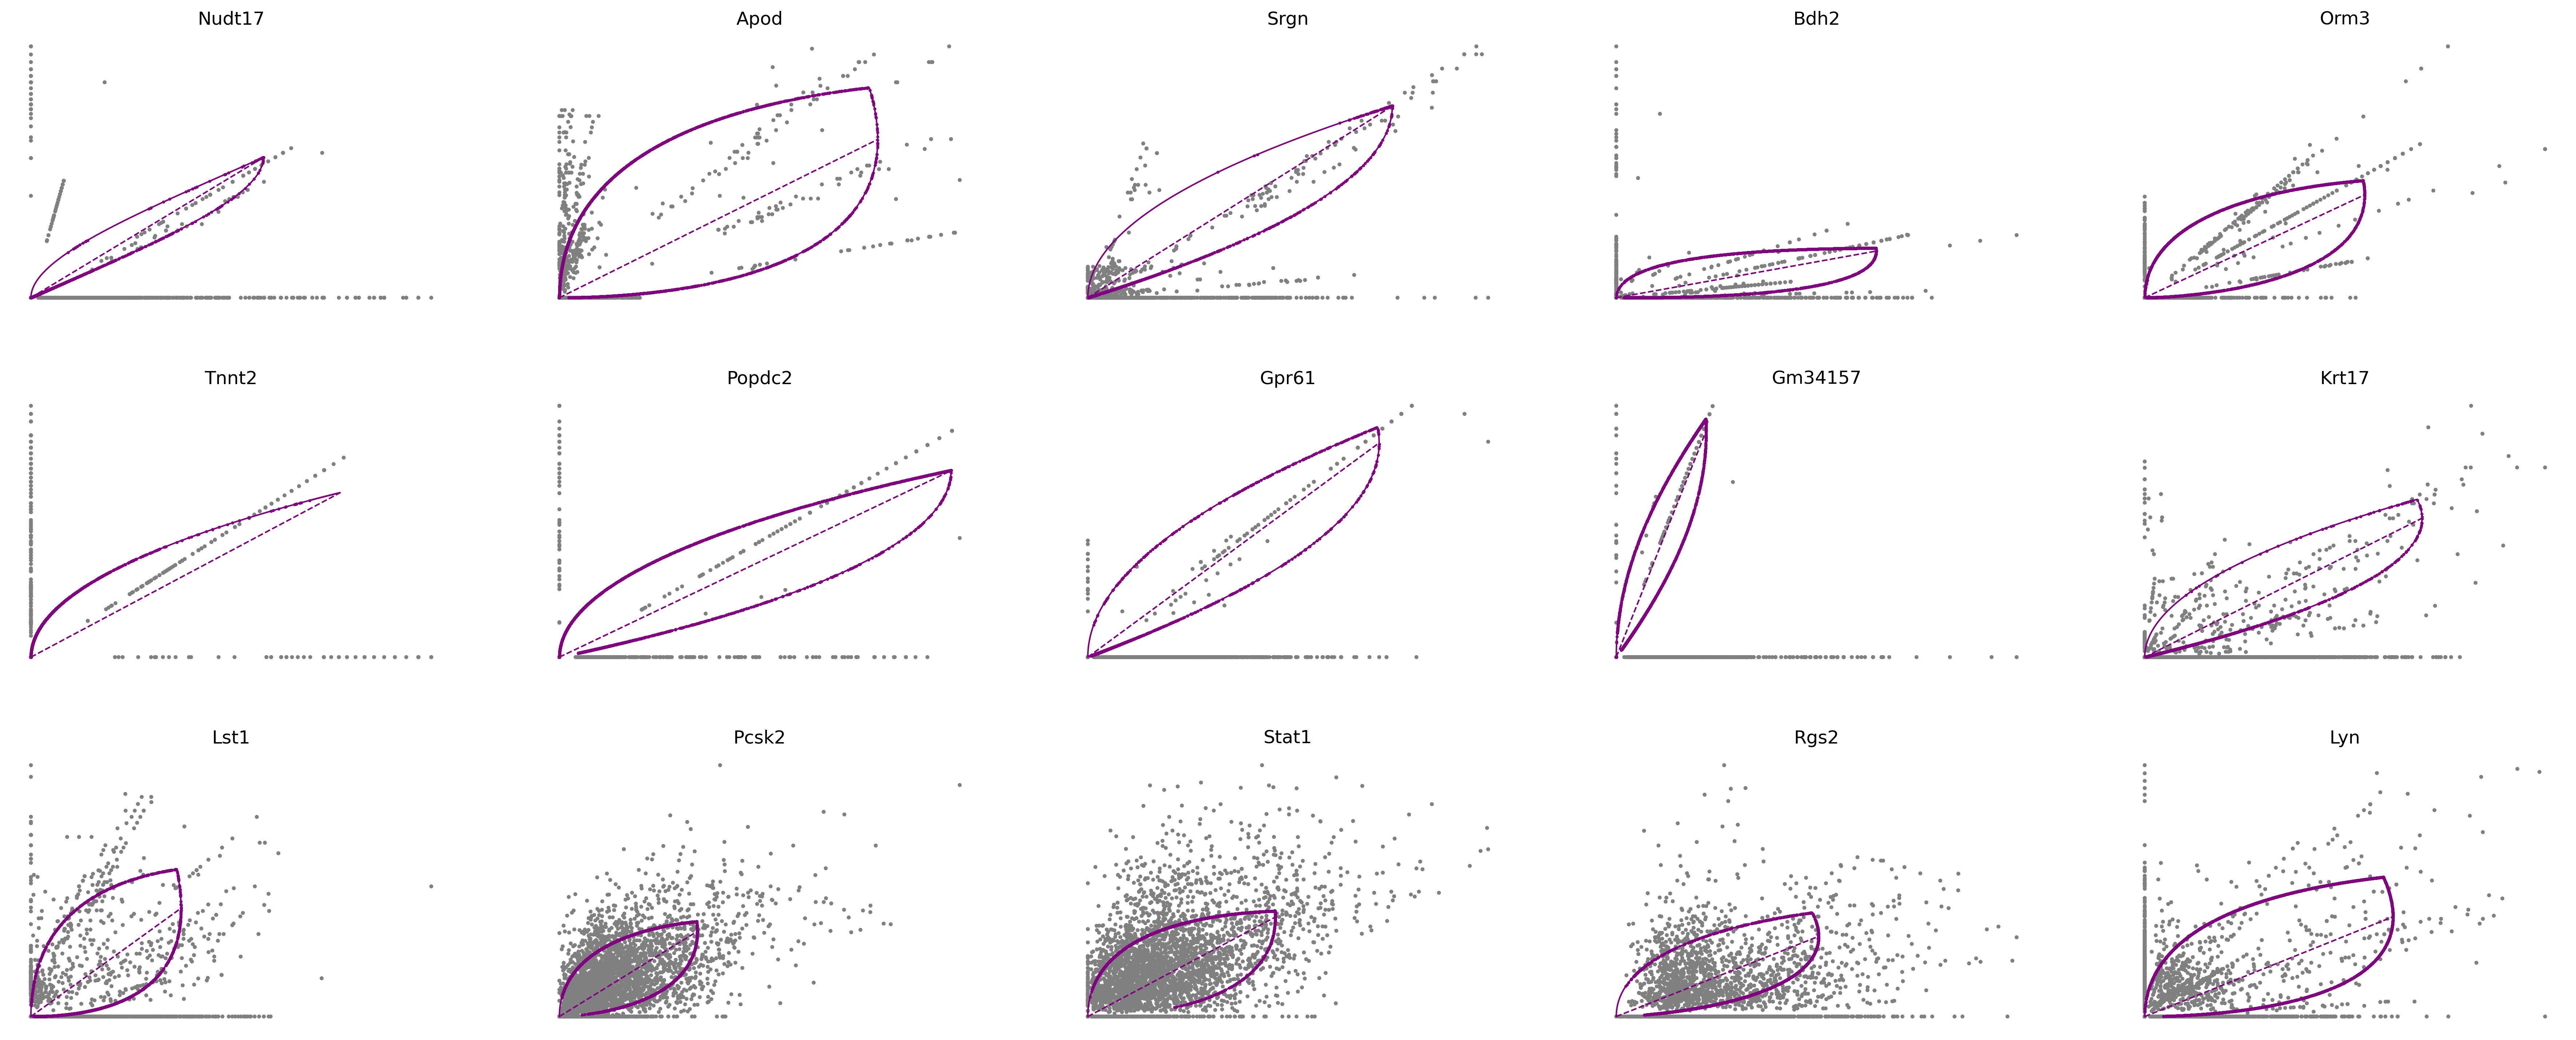

In [29]:
top_genes = pou1f1_dep.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(pou1f1_dep, basis=top_genes[:15], ncols=5, frameon=False)

### Cluster-specific top-likelihood genes
Partial gene likelihoods can be computed for each cluster of cells to enable cluster-specific identification of potential drivers.

In [30]:
scv.tl.rank_dynamical_genes(pou1f1_dep, groupby='leiden')
df = scv.get_df(pou1f1_dep, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:00) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


0        1         2        3        4        5       6        7  \
0      Prg4   Ms4a6d    Nudt17     Penk    Ms4a7    Cd59b    Saa2  Gm34157   
1    Pabpc5   Ifi205  Eif4ebp3     Rgs4     Aif1    Gpr61   Pcsk2      Npy   
2  Timeless   Popdc2     Anxa1      Fgg  Col14a1  Gm41774     Id2    Psg21   
3      Orm3  Plekhg2      Ccl7    Stmn3  Gm34651   Lgals3   H2-K1      Id3   
4     Stat1     Apod      Retn  Slc6a14     Rtp4    Sytl1  Trafd1    Nradd   

         8        9      10             11        12  
0    Josd1   Stard4    Rac2         H2-Ab1      Bdh2  
1    Tgfbi  Gm32585    Lst1          Ube2c  Pisd-ps1  
2  Gm13523  Gm11665  Lgals3           Syt2      Six6  
3    Stat1  Clec4a3  Cited2  C430049B03Rik       Mt3  
4     Ctss    Snhg5   Gngt2          H2-Aa      Btg2